In [1]:
import numpy as np
import os, glob
from keras.preprocessing import image as kImage
from skimage.transform import pyramid_gaussian
from keras.models import load_model
import matplotlib.pyplot as plt
from my_upsampling_2d import MyUpSampling2D
def getData(input_path):
    X = []
    for p in input_path:
        x = kImage.load_img(p)
        x = kImage.img_to_array(x)
        X.append(x)
    X = np.asarray(X)

    s1 = X
    del X
    s2 = []
    s3 = []
    for x in s1:
       pyramid = tuple(pyramid_gaussian(x/255., max_layer=2, downscale=2))
       s2.append(pyramid[1]*255.)
       s3.append(pyramid[2]*255.)
    s2 = np.asarray(s2)
    s3 = np.asarray(s3)
    
    return [s1, s2, s3]

Using TensorFlow backend.


In [2]:
# get data
input_path = glob.glob(os.path.join('sample_test_frames', 'highway', '*.jpg')) # path to your test frames
data = getData(input_path)
print (data[0].shape, data[1].shape, data[2].shape)

(5, 240, 320, 3) (5, 120, 160, 3) (5, 60, 80, 3)


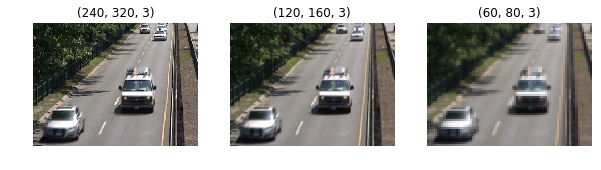

In [3]:
# plot last frame in 3 diff scales
num_in_row = 1
num_in_col = 3
frame_idx = 3 # display frame index

plt.rcParams['figure.figsize'] = (10.0, 7.0) # set figure size

for i in range(num_in_row * num_in_col):
    x = data[i][frame_idx]
    plt.subplot(num_in_row, num_in_col, i+1)
    plt.imshow(x.astype('uint8'))
    
    plt.title(x.shape)
    plt.axis('off')
    
plt.show()

In [4]:
# Segment on a single CPU for this test

# a sample FgSegNet_M model can be downloaded at https://drive.google.com/open?id=1KiEChAxuweEZHwqT5HrkTCbSjT9MxwUF
mdl_path = 'mdl_highway_50frames.h5'

model = load_model(mdl_path, custom_objects={'MyUpSampling2D': MyUpSampling2D}) # load the saved model that is trained with 50 frames
probs = model.predict(data, batch_size=1, verbose=1)
print(probs.shape) # (5, 240,320,1)
probs = probs.reshape([probs.shape[0], probs.shape[1], probs.shape[2]])
print(probs.shape) # (5, 240,320)

5/5 [==============================] - 16s    
(5, 240, 320, 1)
(5, 240, 320)


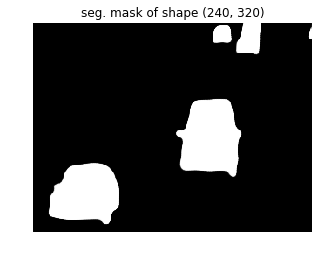

In [6]:
# plot the first segmentation mask
x = probs[frame_idx]

plt.subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(x)

plt.title('seg. mask of shape ' + str(x.shape))
plt.axis('off')
plt.show()

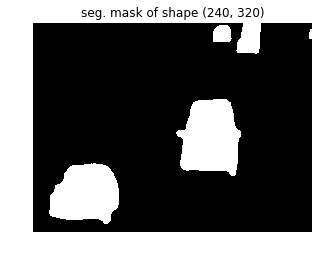

In [7]:
# Thresholding (one can specify any threshold values)
threshold = 0.8
x[x<threshold] = 0.
x[x>=threshold] = 1.

plt.subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['image.cmap'] = 'gray'

plt.imshow(x)

plt.title('seg. mask of shape ' + str(x.shape))
plt.axis('off')
plt.show()
